# Recommender- Yeah Money Money Money

### Requirements
```
python 3.6

numpy == '1.14.3'
pandas == '0.23.0'
tensorflow == '1.8.0'
keras == '2.2.0'
```
Other versions of above library will probably work

Prepare the csv data, from [movielens](https://grouplens.org/datasets/movielens/)

In [1]:
# %cd /data
# !!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
# !!unzip ml-latest-small.zip

In [4]:
import pandas as pd
import numpy as np
import os

In [287]:
DATA = "/data/ml-latest-small/"
DIM = 100 # dimension for embedding

In [288]:
files = os.listdir(DATA)
files

['links.csv', 'tags.csv', 'ratings.csv', 'README.txt', 'movies.csv']

In [289]:
data = dict()
for f in files:
    if f[-3:]=="csv":
        data[f.split(".")[0]] = pd.read_csv(DATA+f)

## Check Sample Data

In [290]:
from IPython.display import display
list(display(k,v.sample(5)) for k,v in data.items())

'links'

,movieId,imdbId,tmdbId
3994,5198,81070,14807.0
4534,6242,178868,2671.0
8187,98083,1753968,65851.0
6944,59315,371746,1726.0
2136,2669,53183,37305.0


'tags'

,userId,movieId,tag,timestamp
1179,547,105504,toplist13,1386245656
819,531,35836,funny,1243454588
975,547,8494,dvd,1254390631
101,179,260,nerdy,1436669973
698,478,55247,road trip,1446622240


'ratings'

,userId,movieId,rating,timestamp
37501,270,1208,4.0,1469278481
56144,405,4357,4.0,1061360768
98876,664,3000,4.0,1343731830
23707,166,5445,4.5,1064887945
66403,468,4545,2.5,1296203102


'movies'

,movieId,title,genres
746,926,All About Eve (1950),Drama
8045,94466,Black Mirror (2011),Drama|Sci-Fi
1804,2282,Pecker (1998),Comedy|Drama
4390,5943,Maid in Manhattan (2002),Comedy|Romance
938,1179,"Grifters, The (1990)",Crime|Drama|Film-Noir


[None, None, None, None]

### What's Collaborative Filtering Like?

In [286]:
pd.crosstab(data["ratings"].userId, data["ratings"].movieId, data["ratings"].rating, aggfunc=np.sum)

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Model On Rating

In [291]:
len(data["ratings"])

100004

In [292]:
userId = list(set(data["ratings"]["userId"]))
movieId = list(set(data["ratings"]["movieId"]))
print(len(userId),len(movieId))

671 9066


### Mapping
user to index, movie to index, index to user, index to movie

Use your own index for each appeared user, movie

In [293]:
u2i = dict((v,k) for k,v in enumerate(userId))
m2i = dict((v,k) for k,v in enumerate(movieId))
i2u = dict((k,v) for k,v in enumerate(userId))
i2m = dict((k,v) for k,v in enumerate(movieId))

In [295]:
data["ratings"]["movie_idx"] = data["ratings"]["movieId"].apply(lambda x:m2i[x])
data["ratings"]["user_idx"] = data["ratings"]["userId"].apply(lambda x:u2i[x])

Keras accepts array, so we turn pandas objects into array

In [298]:
user_array = data["ratings"]["user_idx"].values.reshape(-1,1)
movie_array = data["ratings"]["movie_idx"].values.reshape(-1,1)
rating_array = data["ratings"]["rating"].values.reshape(-1,1)/5

In [301]:
rating_array

array([[0.5],
       [0.6],
       [0.6],
       ...,
       [0.8],
       [0.5],
       [0.7]])

Check shapes on data

In [302]:
user_array.shape,movie_array.shape,rating_array.shape

((100004, 1), (100004, 1), (100004, 1))

## Model

In [303]:
from keras.layers import *
from keras.models import *

In [304]:
def idx2vec(leng,name,dim = DIM):
    """
    leng: length of vector
    name: name the input layer
    dim: hidden dimension of embedding
    return: input tensor, embedding layer
    """
    ipt = Input((1,),name=name+"_ipt")
    ebd = Embedding(leng,dim)(ipt)
    ebd = SpatialDropout1D(.3)(ebd)
    return ipt,ebd

In [305]:
ipt_u, ebd_u = idx2vec(len(userId),"user")
ipt_m, ebd_m = idx2vec(len(movieId),"movie")

In [308]:
user2vec = Model(ipt_u,ebd_u)
movie2vec = Model(ipt_m,ebd_m)

### Check What's Embeding Layer

In [307]:
user2vec.predict(np.array([[0],[2]]))

array([[[-3.30460444e-02, -2.59602908e-02, -1.15970857e-02,
          2.40817778e-02, -1.02825873e-02, -4.36714999e-02,
         -2.60997936e-03, -2.55534295e-02,  6.12873957e-03,
         -4.28985432e-03,  4.22970913e-02, -1.29304826e-04,
          2.07059048e-02, -4.12533656e-02, -3.29330713e-02,
          8.31794739e-03, -4.42209505e-02, -1.93640590e-02,
          2.84278132e-02, -3.13772447e-02, -4.35863622e-02,
          3.19475792e-02, -4.98196743e-02,  3.09588350e-02,
         -1.36613734e-02,  3.31640877e-02,  3.34727280e-02,
         -1.59128532e-02,  1.42641105e-02, -1.93850994e-02,
          2.89269947e-02, -4.93724123e-02,  3.35616581e-02,
         -3.40440162e-02, -4.71961983e-02,  1.45145990e-02,
         -2.31239926e-02, -2.75325309e-02, -3.26253660e-02,
         -2.33692527e-02,  1.86637901e-02,  1.75088644e-06,
         -3.58017311e-02,  4.80211638e-02,  8.66247341e-03,
         -2.87798401e-02, -2.17184424e-02,  4.96555008e-02,
         -4.87562530e-02,  4.12024744e-0

In [314]:
x = Multiply()([ebd_u,ebd_m])
x = Flatten()(x)
x = Dense(1,)(x)

cf = Model([ipt_u,ipt_m],x)

In [315]:
cf.compile("Adam",loss="mae",)

In [316]:
cf.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_ipt (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
movie_ipt (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, 1, 100)       67100       user_ipt[0][0]                   
__________________________________________________________________________________________________
embedding_34 (Embedding)        (None, 1, 100)       906600      movie_ipt[0][0]                  
__________________________________________________________________________________________________
spatial_dr

In [317]:
cf.fit([user_array,movie_array],rating_array,epochs=5,shuffle=True,validation_split=.3,batch_size=512)

Train on 70002 samples, validate on 30002 samples
Epoch 1/5
70002/70002 [==============================] - 4s 63us/step - loss: 0.5276 - val_loss: 0.5825
Epoch 2/5
70002/70002 [==============================] - 3s 40us/step - loss: 0.2006 - val_loss: 0.5236
Epoch 3/5
70002/70002 [==============================] - 3s 40us/step - loss: 0.1556 - val_loss: 0.4985
Epoch 4/5
70002/70002 [==============================] - 3s 40us/step - loss: 0.1393 - val_loss: 0.4794
Epoch 5/5
70002/70002 [==============================] - 3s 41us/step - loss: 0.1306 - val_loss: 0.4639


### Deep Collaborative Filtering

In [319]:
ipt_u, ebd_u = idx2vec(len(userId),"user")
ipt_m, ebd_m = idx2vec(len(movieId),"movie")

x = Multiply()([ebd_u,ebd_m])
x = Flatten()(x)

# The rest is multi-layer perceptron
x = Dense(256,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.5)(x)
x = Dense(128,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.5)(x)
x = Dense(1,use_bias=False)(x)

In [320]:
cf_dnn = Model([ipt_u,ipt_m],x)

In [321]:
cf_dnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_ipt (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
movie_ipt (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_37 (Embedding)        (None, 1, 100)       67100       user_ipt[0][0]                   
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, 1, 100)       906600      movie_ipt[0][0]                  
__________________________________________________________________________________________________
spatial_dr

In [322]:
cf_dnn.compile("Adam",loss="mse",)

In [323]:
cf_dnn.fit([user_array,movie_array],rating_array,epochs=3,shuffle=True,validation_split=.1,batch_size=512)

Train on 90003 samples, validate on 10001 samples
Epoch 1/3
90003/90003 [==============================] - 10s 109us/step - loss: 0.2729 - val_loss: 0.0482
Epoch 2/3
90003/90003 [==============================] - 7s 80us/step - loss: 0.0622 - val_loss: 0.0468
Epoch 3/3
90003/90003 [==============================] - 7s 80us/step - loss: 0.0548 - val_loss: 0.0442


In [330]:
cf_dnn.predict([np.array([5]),np.array([4])])*5

array([[3.622812]], dtype=float32)

### Visualization

In [332]:
cf_weights = cf_dnn.get_weights()

for w in cf_weights:
    print(w.shape)

(671, 100)
(9066, 100)
(100, 256)
(256,)
(256,)
(256,)
(256,)
(256, 128)
(128,)
(128,)
(128,)
(128,)
(128, 1)


In [333]:
movie_vec = cf_weights[1]
movie_vec.shape

(9066, 100)

In [334]:
from sklearn.decomposition import PCA
# using principal component analysis to decompose the 100 dimensions
# compressing to 3 dimensions
pca = PCA(n_components=3,)

In [335]:
%time movie_3d = pca.fit_transform(movie_vec)

CPU times: user 71.9 ms, sys: 9 ms, total: 80.9 ms
Wall time: 42.7 ms


In [336]:
movie_3d

array([[-0.02111751, -0.02028077, -0.02052776],
       [-0.05166073,  0.00858772,  0.0260797 ],
       [-0.02160499, -0.03896006, -0.0067747 ],
       ...,
       [-0.01275731, -0.00377434,  0.03801192],
       [-0.02981995, -0.01292933, -0.01477792],
       [-0.05492761,  0.01296559, -0.01981016]], dtype=float32)

In [337]:
most_watched = pd.DataFrame(data["ratings"]["movieId"].value_counts())

In [338]:
most_watched = most_watched.reset_index().rename(columns={"index":"mid","movieId":"counts"})

In [339]:
mid2title = dict(zip(data["movies"]["movieId"],data["movies"]["title"]))
mid2genres = dict(zip(data["movies"]["movieId"],data["movies"]["genres"]))

In [340]:
mid2title

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (a.k.a. 12 Monkeys) (199

In [341]:
most_watched["title"] = most_watched["mid"].apply(lambda x:mid2title[x])

In [342]:
most_watched.head(15)

,mid,counts,title
0,356,341,Forrest Gump (1994)
1,296,324,Pulp Fiction (1994)
2,318,311,"Shawshank Redemption, The (1994)"
3,593,304,"Silence of the Lambs, The (1991)"
4,260,291,Star Wars: Episode IV - A New Hope (1977)
5,480,274,Jurassic Park (1993)
6,2571,259,"Matrix, The (1999)"
7,1,247,Toy Story (1995)
8,527,244,Schindler's List (1993)
9,589,237,Terminator 2: Judgment Day (1991)


In [343]:
most_watched_ebd_idx = most_watched["mid"].apply(lambda x:m2i[x]).values

In [344]:
most_watched["vec_1"] = movie_3d[most_watched_ebd_idx][:,0]
most_watched["vec_2"] = movie_3d[most_watched_ebd_idx][:,1]
most_watched["vec_3"] = movie_3d[most_watched_ebd_idx][:,2]

In [345]:
most_watched.head(300).sort_values(by = "vec_1")

,mid,counts,title,vec_1,vec_2,vec_3
192,508,86,Philadelphia (1993),-0.064901,0.020036,-0.008784
100,1961,119,Rain Man (1988),-0.064252,-0.017032,-0.047262
273,903,69,Vertigo (1958),-0.062546,-0.009131,0.005182
147,1258,101,"Shining, The (1980)",-0.057882,0.027212,-0.017096
226,1028,78,Mary Poppins (1964),-0.055210,0.001238,0.006531
229,1625,76,"Game, The (1997)",-0.052415,-0.008257,-0.025971
127,2,107,Jumanji (1995),-0.051661,0.008588,0.026080
21,590,202,Dances with Wolves (1990),-0.051624,-0.000504,-0.005979
72,4226,132,Memento (2000),-0.047003,0.017175,0.007325
182,1079,89,"Fish Called Wanda, A (1988)",-0.046228,-0.020493,-0.033207


In [346]:
most_watched.head(300).sort_values(by = "vec_2")

,mid,counts,title,vec_1,vec_2,vec_3
259,368,71,Maverick (1994),-0.019251,-0.081542,-0.007033
217,1391,80,Mars Attacks! (1996),-0.012707,-0.080271,0.051152
122,2987,108,Who Framed Roger Rabbit? (1988),0.015495,-0.075618,-0.023854
280,2395,68,Rushmore (1998),0.013302,-0.068364,0.015651
112,208,113,Waterworld (1995),-0.006537,-0.057502,0.011053
248,1101,74,Top Gun (1986),0.003654,-0.052434,-0.029896
6,2571,259,"Matrix, The (1999)",-0.004821,-0.051701,0.029076
170,141,93,"Birdcage, The (1996)",0.035209,-0.050537,-0.053623
62,165,142,Die Hard: With a Vengeance (1995),0.002055,-0.047892,-0.044821
31,2762,193,"Sixth Sense, The (1999)",-0.002274,-0.047302,-0.000830


In [347]:
most_watched.head(300).sort_values(by = "vec_3")

,mid,counts,title,vec_1,vec_2,vec_3
46,231,158,Dumb & Dumber (Dumb and Dumber) (1994),0.021526,0.016344,-0.101643
129,7361,106,Eternal Sunshine of the Spotless Mind (2004),-0.023263,-0.001144,-0.066678
152,3751,99,Chicken Run (2000),-0.019505,0.006631,-0.064933
101,111,118,Taxi Driver (1976),-0.004734,-0.025892,-0.061280
209,8360,81,Shrek 2 (2004),0.001541,0.016775,-0.058592
99,1732,120,"Big Lebowski, The (1998)",0.066197,0.036355,-0.054685
170,141,93,"Birdcage, The (1996)",0.035209,-0.050537,-0.053623
139,2174,104,Beetlejuice (1988),-0.034805,-0.005558,-0.053593
190,17,86,Sense and Sensibility (1995),0.048765,0.015316,-0.049722
244,1278,74,Young Frankenstein (1974),0.057950,0.020931,-0.049185


### Scatter Chart

In [348]:
from sklearn.decomposition import PCA
# using principal component analysis to decompose the 100 dimensions
# compressing to 3 dimensions
pca = PCA(n_components=2,)
%time movie_2d = pca.fit_transform(movie_vec)


CPU times: user 71.4 ms, sys: 4.47 ms, total: 75.9 ms
Wall time: 38 ms


In [349]:
most_watched["vec_1"] = movie_2d[most_watched_ebd_idx][:,0]
most_watched["vec_2"] = movie_2d[most_watched_ebd_idx][:,1]

In [350]:
from matplotlib import pyplot as plt
% matplotlib inline

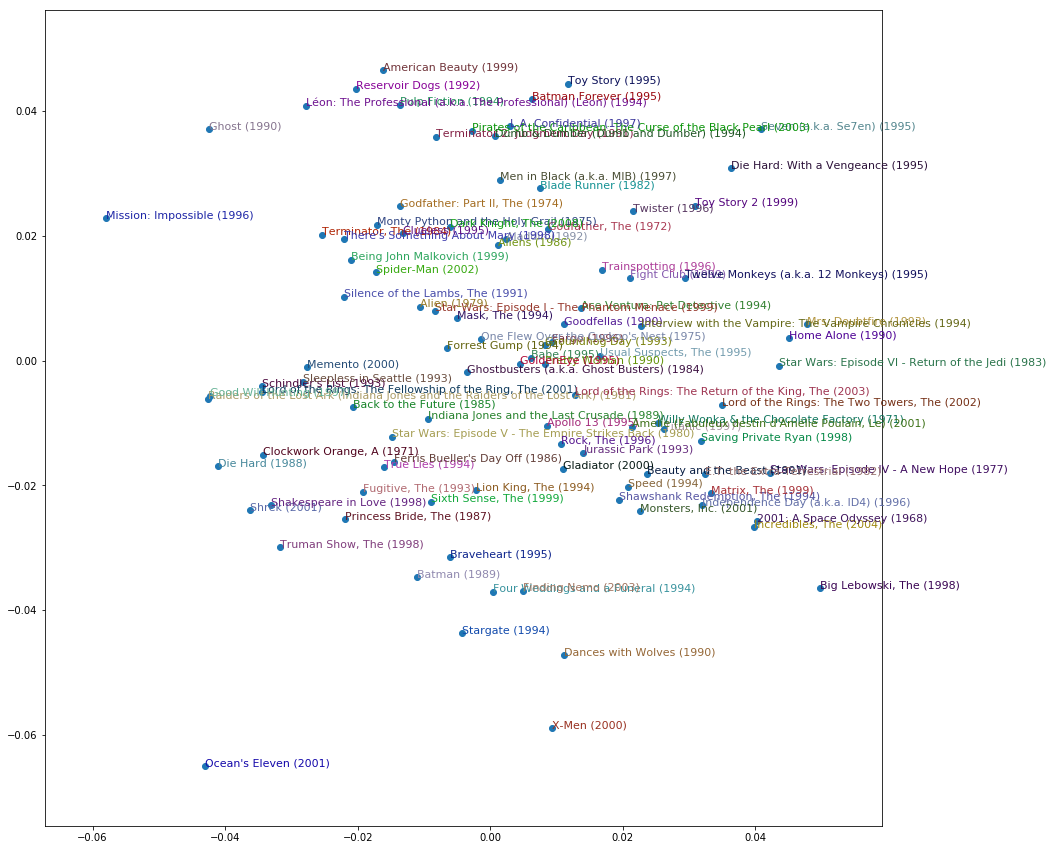

In [351]:
X = most_watched.head(100)["vec_1"]
Y = most_watched.head(100)["vec_2"]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(most_watched["title"], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Excercise

* Run through this notebook
* Try the [pytorch version here](experiments/collaborative_filtering_movie_lens.ipynb)
* Try the [20 million larger version of data](https://grouplens.org/datasets/movielens/)(about 20 million ratings rows)

### About Homework

when the code mentioned ray, like from ray.matchbox import ....

ray is a library I built for myself. Just put the repository inside your pathon path

For example, if you are using anaconda3. you can do:

```
cd ~/anaconda3/lib/python3.6/site-packages/
```